In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
import tensorflow as tf
import numpy as np
import random
import os

seed = 42  # Set a fixed seed
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [39]:
# Define paths
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"

Reproducibility is a great concern when doing deep learning. There was a good discussion on KaggleNoobs slack regarding this. We will set a numer of things in order to make sure that the results are almost reproducible(if not fully).

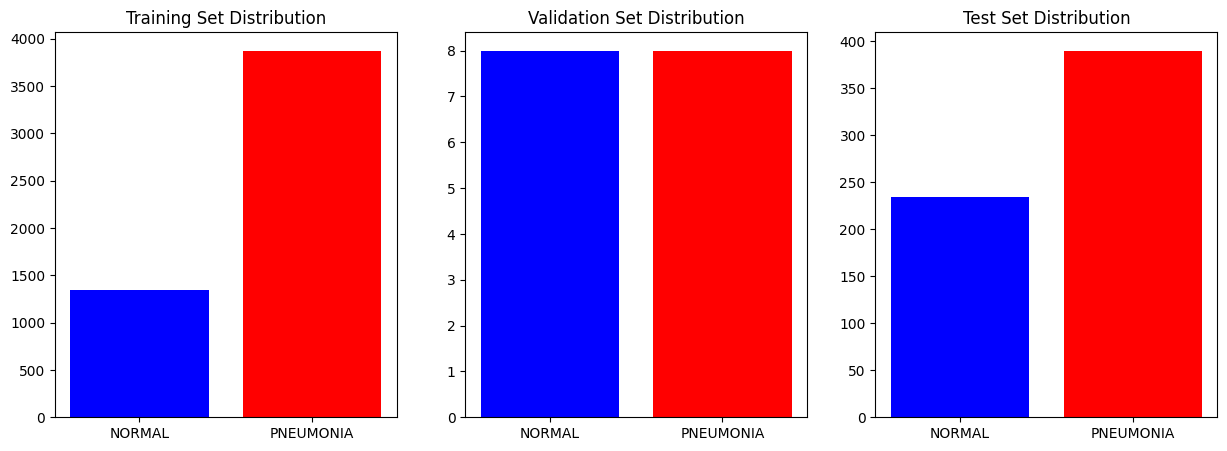

In [40]:
import os
import matplotlib.pyplot as plt

# Function to count images in each category
def count_images(directory):
    return {category: len(os.listdir(os.path.join(directory, category))) for category in ["NORMAL", "PNEUMONIA"]}

# Get image counts
train_counts = count_images("/kaggle/input/chest-xray-pneumonia/chest_xray/train/")
val_counts = count_images("/kaggle/input/chest-xray-pneumonia/chest_xray/val/")
test_counts = count_images("/kaggle/input/chest-xray-pneumonia/chest_xray/test/")

# Plot distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (dataset, counts) in enumerate(zip(["Training", "Validation", "Test"], [train_counts, val_counts, test_counts])):
    ax[i].bar(counts.keys(), counts.values(), color=['blue', 'red'])
    ax[i].set_title(f"{dataset} Set Distribution")

plt.show()

As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. This situation is very normal when it comes to medical data. The data will always be imbalanced. either there will be too many normal cases or there will be too many cases with the disease.

Let's look at how a normal case is different from that of a pneumonia case. We will look at somes samples from our training data itself.

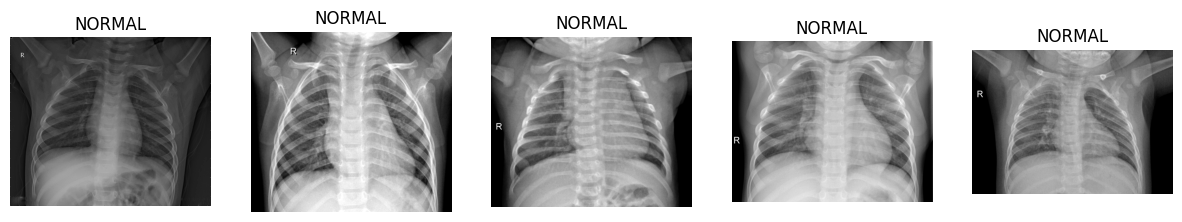

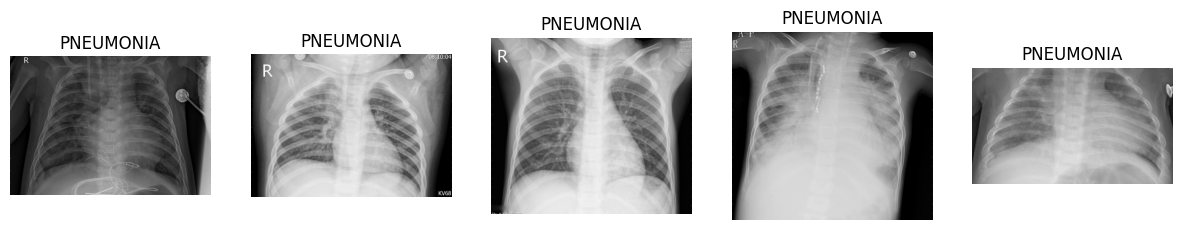

In [41]:
import cv2

# Function to plot images
def plot_images(category, dataset_path, num_images=5):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)[:num_images]  # Select first few images

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE)  # Read image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(category)
        axes[i].axis('off')

    plt.show()

# Show images from both categories
plot_images("NORMAL", train_path)
plot_images("PNEUMONIA", train_path)

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.

In [16]:
import os

train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
normal_path = os.path.join(train_dir, "NORMAL")
pneumonia_path = os.path.join(train_dir, "PNEUMONIA")

normal_images = os.listdir(normal_path)
pneumonia_images = os.listdir(pneumonia_path)

print(f"Normal Images: {len(normal_images)}")
print(f"Pneumonia Images: {len(pneumonia_images)}")

Normal Images: 1341
Pneumonia Images: 3875


# Balancing an Imbalanced Dataset
In machine learning, having a balanced dataset is important because an imbalanced dataset can cause a model to become biased towards the majority class. There are many ways to fix class imbalance, but for this project, we used a simple approach — undersampling the majority class.

What we did:

We had two classes in the Chest X-Ray dataset:

NORMAL (healthy lungs)

PNEUMONIA (infected lungs)

The number of images in these two classes was not equal — there were more 'PNEUMONIA' images than 'NORMAL' images. To balance the data, we took the following steps:

Count images in both classes:

Get the list of images in both 'NORMAL' and 'PNEUMONIA' folders.

Find the minimum count:

We found the size of the smaller class and used that count to sample the same number of images from the larger class.

Random sampling:

Randomly picked images from both classes to match the size of the smaller class.

Copy images to a new folder:

Created a new folder structure where both classes had the same number of images.

**I chose this method because it was quick and easy to implement, and it helped ensure that my model doesn’t get biased toward one class.**

In [42]:
import os
import random
import shutil

def copy_and_balance_data(source_dir, dest_dir, seed=42):
    random.seed(seed)  # Set the random seed for reproducibility
    os.makedirs(dest_dir, exist_ok=True)
    
    # Define category paths
    normal_src = os.path.join(source_dir, "NORMAL")
    pneumonia_src = os.path.join(source_dir, "PNEUMONIA")
    
    normal_dest = os.path.join(dest_dir, "NORMAL")
    pneumonia_dest = os.path.join(dest_dir, "PNEUMONIA")
    
    os.makedirs(normal_dest, exist_ok=True)
    os.makedirs(pneumonia_dest, exist_ok=True)

    # Get image lists
    normal_images = os.listdir(normal_src)
    pneumonia_images = os.listdir(pneumonia_src)

    # Balance dataset (Take minimum count)
    min_count = min(len(normal_images), len(pneumonia_images))

    # Randomly sample images
    normal_sample = random.sample(normal_images, min_count)
    pneumonia_sample = random.sample(pneumonia_images, min_count)

    # Copy sampled images to new location
    for img in normal_sample:
        shutil.copy(os.path.join(normal_src, img), os.path.join(normal_dest, img))

    for img in pneumonia_sample:
        shutil.copy(os.path.join(pneumonia_src, img), os.path.join(pneumonia_dest, img))

    print(f"Balanced dataset created at {dest_dir}: {min_count} NORMAL, {min_count} PNEUMONIA")

# Source (Read-only) and Destination (Writable) Directories
source_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
dest_path = "/kaggle/working/balanced_chest_xray/train/"

# Run function
copy_and_balance_data(source_path, dest_path)


Balanced dataset created at /kaggle/working/balanced_chest_xray/train/: 1341 NORMAL, 1341 PNEUMONIA


In [43]:
balanced_data_path="/kaggle/working/balanced_chest_xray/train/"

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32
seed=42

## Data Augmentation and Generators
To improve the model's ability to generalize, we used data augmentation with Keras' ImageDataGenerator. This helps the model learn better by slightly altering the images during training, making it more robust.

In [45]:
# Function to count images
def count_images(path):
    total_images = sum([len(files) for _, _, files in os.walk(path)])
    return total_images

# Count images in each set
train_size = count_images(train_path)
val_size = count_images(val_path)
test_size = count_images(test_path)

print(f"📊 Dataset Sizes:")
print(f"Training set: {train_size} images")
print(f"Validation set: {val_size} images")
print(f"Test set: {test_size} images")

📊 Dataset Sizes:
Training set: 5216 images
Validation set: 16 images
Test set: 624 images


In [47]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.6, 1.2],
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
)
# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=balanced_data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=seed
)
# Validation Data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    directory=val_path,  # Still using train (with subset)
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=seed
)

# Test Data (No subset needed)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,  # Use test folder
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False , # No need to shuffle test data
    seed=seed
)
# ✅ Check Class Labels
print("Class labels:", train_generator.class_indices)

Found 2146 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


In [48]:
vgg='/kaggle/input/vgggggg/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [49]:
import os
print(os.listdir('/kaggle/input/vgggggg/'))


['vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5']


## Model Building
This is the most exciting part! If you look at other solutions for this dataset, most people are using transfer learning by fine-tuning large models. While transfer learning is useful, it's important to use it wisely. Instead of completely relying on a pre-trained model, we’ll combine transfer learning with training some parts of our model from scratch.

Before jumping into the code, here are some best practices for training deep learning models when you have limited data:

Keep the architecture simple. A complex model isn’t always better.

Use a pre-trained model for the first few layers. These layers learn basic features like colors, edges, and textures, so instead of training them from scratch, we’ll fine-tune them.

Use efficient layers. Instead of regular convolutional layers, we can use Depthwise Separable Convolutions, which reduce the number of parameters while capturing important details.

Apply Batch Normalization. This helps stabilize training, especially for deeper networks.

Use dense layers wisely. Start with a higher learning rate to find a good network depth and neuron count, then fine-tune with a lower learning rate.

Gradually decrease the learning rate. Once we get a good structure, we lower the learning rate to refine the model.
### 📦 Model Architecture
We followed these steps to build the model:

Load VGG19:
Used pretrained weights (imagenet).
Excluded the top layers (include_top=False) to customize the output for our task.
Freezing layers:
Initially froze all layers to preserve learned features.
Unfroze the last 7 layers to allow fine-tuning.
Added custom layers:
GlobalAveragePooling2D: Reduces feature maps and prevents overfitting.
Dense layers: Added fully connected layers with ReLU activation.
Batch Normalization: Included for batch sizes > 32 to stabilize learning.
Output layer:
A final Dense(1) layer with sigmoid activation for binary classification — predicting Normal or Pneumonia.
### 📈 Training the Model
We trained the model using callbacks to improve efficiency and performance:

EarlyStopping: Stops training if val_loss doesn’t improve for 5 epochs.
ReduceLROnPlateau: Reduces learning rate by 50% if validation loss plateaus for 3 epochs.
ModelCheckpoint: Saves the best model based on validation accuracy.
### 🚀 Why use Transfer Learning?
Speeds up training: Instead of training from scratch, we build upon existing knowledge (VGG19).
Better accuracy: Pretrained models capture complex patterns from large datasets (like ImageNet).
Fine-tuning: Allows customization for our pneumonia detection task without losing learned features.

In [50]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_model(batch_size):
    # ✅ Load Pretrained VGG19
    base_model = VGG19(weights=vgg, include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last 7 layers
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    # ✅ Build Model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    ])

    # ✅ Batch Normalization for larger batch sizes
    if batch_size > 32:
        model.add(BatchNormalization())

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

    if batch_size > 32:
        model.add(BatchNormalization())

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

    if batch_size > 32:
        model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    # ✅ Compile Model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ✅ Create & Train the Model
batch_size = 32
model = build_model(batch_size)

# ✅ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)
]

# ✅ Train the Model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 50s 617ms/step - accuracy: 0.7359 - loss: 10.2682 - val_accuracy: 0.7500 - val_loss: 9.0040 - learning_rate: 1.0000e-04
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 594ms/step - accuracy: 0.9049 - loss: 8.3315 - val_accuracy: 0.8125 - val_loss: 7.3708 - learning_rate: 1.0000e-04
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 580ms/step - accuracy: 0.9387 - loss: 6.8402 - val_accuracy: 0.6875 - val_loss: 6.2242 - learning_rate: 1.0000e-04
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 579ms/step - accuracy: 0.9237 - loss: 5.7115 - val_accuracy: 0.6875 - val_loss: 5.2288 - learning_rate: 1.0000e-04
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 594ms/step - accuracy: 0.9474 - loss: 4.7029 - val_accuracy: 0.9375 - val_loss: 4.0615 - learning_rate: 1.0000e-04
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 591ms/step - accuracy: 0.9693 - loss: 3.8637 - val_accuracy: 1.0000 - val_loss: 3.3380 - learning_rate: 1.0000e-04
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 585ms/step - accuracy: 0.9

In [25]:
# ✅ Evaluate Model
results = model.evaluate(test_generator)
test_loss, test_accuracy = results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
#print(f"Test AUC: {test_auc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.9293 - loss: 0.2210
Test Loss: 0.2671
Test Accuracy: 90.71%


In [26]:
# ✅ Evaluate and print all metrics
results = model.evaluate(test_generator)
metrics = dict(zip(model.metrics_names, results))
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9293 - loss: 0.2210
loss: 0.2671
compile_metrics: 0.9071


The Test Loss shows how well the model performed on unseen data — lower is better.
The Test Accuracy of 90.71% indicates how accurately the model classified test samples.
Compile Metrics reflect training-time accuracy, which was 92.93%.

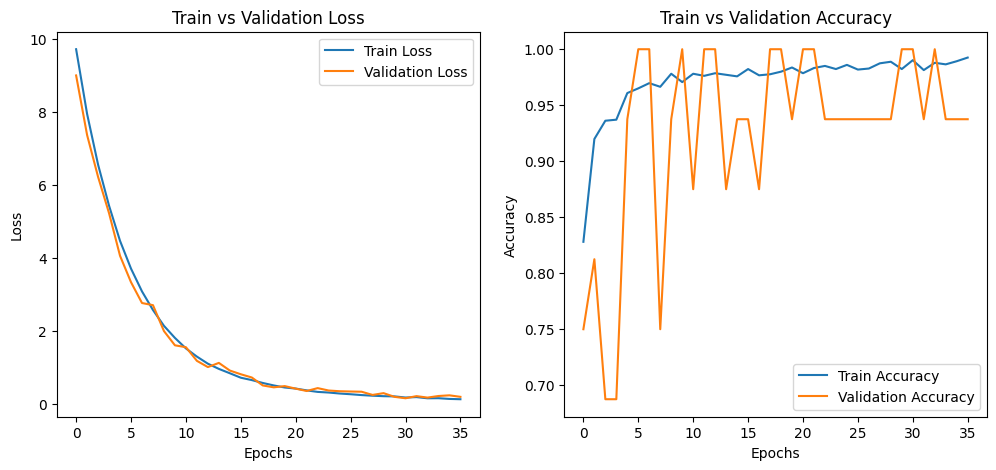

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.show()

## 📊 Training vs Validation Metrics
### 📉 Loss Curve
The Train Loss and Validation Loss both decrease consistently as the epochs increase.
This indicates the model is learning well without overfitting — both curves follow a similar path and converge towards zero.
### 📈 Accuracy Curve
Train Accuracy shows steady improvement, reaching almost 100% by the end.
Validation Accuracy fluctuates, showing some instability — bouncing between 70% to 100%.
This suggests there might be some variance in the validation set or potential overfitting in later epochs.

**Model improvement is an ongoing process, and we’ll keep refining it step by step!**

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.90       234
   Pneumonia       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.92      0.92       624



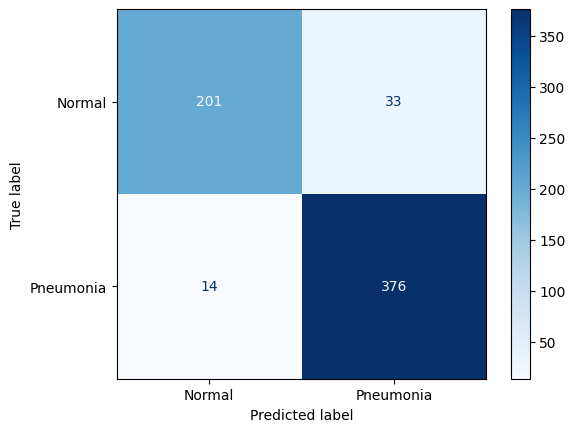

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
true_labels = test_generator.classes
predictions = (model.predict(test_generator) > 0.5).astype("int32")

# Classification Report
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.show()

Accuracy=(TP+TN)/Total_Samples=0.9293=(92.93%)
         
## ✅ Key Insights
Accuracy: 92% — The model correctly predicts the class labels for 92% of the test samples.
### Precision:
* Normal: 93% — Out of all the samples predicted as     "Normal," 93% were actually "Normal."
* Pneumonia: 92% — Out of all the samples predicted as "Pneumonia," 92% were actually "Pneumonia."
### Recall:
* Normal: 86% — The model correctly identified 86% of the "Normal" cases.
* Pneumonia: 96% — The model correctly identified 96% of the "Pneumonia" cases.


In [ ]:
from tensorflow.keras.models import load_model
model.save("my_model.keras")   # Save Model

# Load Model for Future Predictions
loaded_model = load_model("my_model.keras")


In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    class_name = "Category 1" if prediction[0][0] > 0.5 else "Category 0"

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()

# Example
predict_image("/kaggle/input/normal-image/images.jpg", loaded_model)

## 🌟 Key Takeaways
* **Solid Accuracy:** The model hit 92.93% accuracy — not bad at all! It’s doing a good job distinguishing between    Normal and Pneumonia cases.
* **Catching Pneumonia:** With a 96% recall for Pneumonia, the model rarely misses a case — super important for early detection!
* **False Alarms:** 93% precision for Normal cases means fewer false alarms, but there’s still space to make it even sharper.
* **Small Accuracy Gap:** The test accuracy was 90.71%, slightly lower than the classification report's accuracy. We’ll dig deeper into why this gap exists — maybe a batch-wise variation or something to tweak!
## 🚀 What’s Next?
* **Balancing the Data:** We’ll use other similar techniques to handle any class imbalance so the model doesn’t lean too much toward one side.
* **Model Tweaks:** More fine-tuning — adjusting learning rates, adding regularization, and playing around with optimizers to squeeze out extra performance.
* **Making It Explainable:** Let’s add Grad-CAM to show which parts of the X-ray influence the model's decision — super useful for doctors!

* **Expert Validation:** Finally, we plan to team up with medical experts for feedback — because real-world impact is the goal!
  
***✨ This is just the beginning! We’re on the right track, and with these improvements, the model's going to get even smarter. Let’s keep building! 💪***






